In [1]:
###############################################################################
# 0. UPLOAD & EXTRACT DATA FROM ZIP FILE (if needed)
###############################################################################
# Uncomment the following lines to upload a zip file.
from google.colab import files
import zipfile, io
#
uploaded = files.upload()

for filename in uploaded.keys():
   if filename.endswith('.zip'):
       print("Extracting from", filename)
       with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as z:
           z.extractall()
       print("Extracted files:", z.namelist())

###############################################################################
# 1. LOAD DATA FROM CSV
###############################################################################
import pandas as pd
# Adjust this path according to your extracted folder structure in Colab:
csv_path = "prod_export_20250412_1744430420/PROCESSED/data_ncov2019.csv"
df = pd.read_csv(csv_path)
print("DataFrame shape:", df.shape)
print(df.head())

Saving data_ncov2019.csv (1).zip to data_ncov2019.csv (1).zip
Extracting from data_ncov2019.csv (1).zip
Extracted files: ['prod_export_20250412_1744430420/PROCESSED/data_ncov2019.csv']
DataFrame shape: (9615934, 19)
  EVENT_NAME              SOURCE    DATE_LOW   DATE_HIGH DATE_REPORT  \
0  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
1  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
2  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
3  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   
4  nCoV_2019  Multisource Fusion  2019-12-12  2019-12-29  2020-01-05   

       DATE_TYPE SPATIAL_RESOLUTION AL0_CODE AL0_NAME AL1_CODE AL1_NAME  \
0  Symptom onset                AL0       CN    China      NaN      NaN   
1  Symptom onset                AL0       CN    China      NaN      NaN   
2  Symptom onset                AL0       CN    China      NaN      NaN   
3  Symptom onset                AL0       CN    Chi

DataFrame shape: (9615934, 19)
Data window: 2020-02-22 00:00:00 → 2021-12-31 00:00:00   length: 679
Supervised data shapes: (665, 14, 4) (665, 4)
Train shape: (573, 14, 4) Test shape: (92, 14, 4)
Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.1572 - val_loss: 0.0151
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0010 - val_loss: 8.0591e-04
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.6190e-04 - val_loss: 0.0013
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.8447e-04 - val_loss: 0.0013
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.9909e-04 - val_loss: 9.3967e-04
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.1210e-04 - val_loss: 0.0011
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.1124e-04 - val_loss: 0.0012
Ep

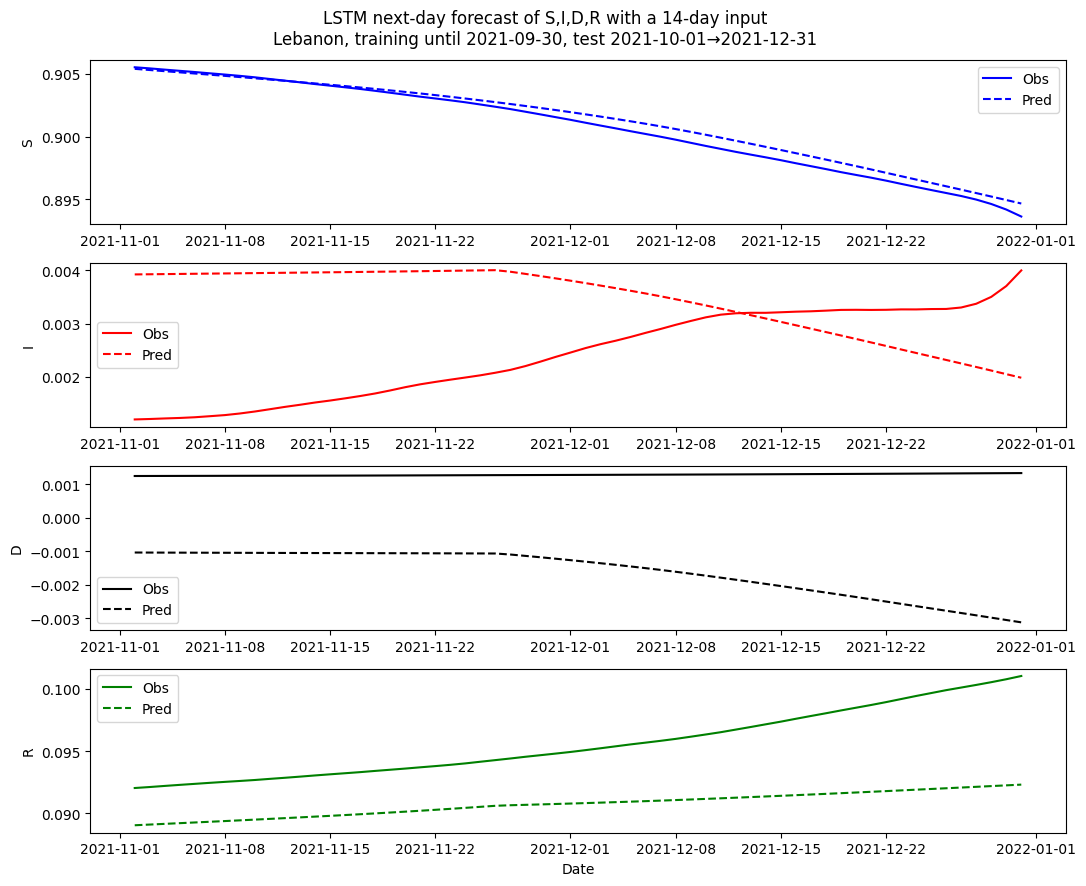

In [18]:
###############################################################################
# 0. USER SETTINGS
###############################################################################
country      = 'Lebanon'
train_start  = '2020-01-01'
train_end    = '2021-09-30'
test_start   = '2021-10-01'
test_end     = '2021-12-31'
pop_N        = 6_800_000     # Population
look_back    = 14            # days of input
epochs       = 150
batch_size   = 32
patience     = 10            # early stopping patience

###############################################################################
# 1. LOAD DATA & BUILD SIDR (INCLUDES D EXPLICITLY)
###############################################################################
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import tensorflow as tf
tf.random.set_seed(0)

# Load CSV (adjust path if needed)
print("DataFrame shape:", df.shape)

def daily(mask):
    sub = df.loc[mask, ['DATE_REPORT','VALUE']].copy()
    sub['DATE'] = pd.to_datetime(sub.DATE_REPORT)
    # group duplicates by date, resample daily, interpolate
    return (sub.set_index('DATE')
              .VALUE.groupby(level=0).mean()
              .asfreq('D').interpolate())

maskC = (df.AL0_NAME==country) & (df.OUTCOME=='CASE')  & (df.CUMULATIVE_FLAG)
maskD = (df.AL0_NAME==country) & (df.OUTCOME=='DEATH') & (df.CUMULATIVE_FLAG)
C = daily(maskC)
D = daily(maskD).reindex(C.index).interpolate().fillna(0)

# Restrict data to the full period (train + test)
C = C.loc[train_start:test_end]
D = D.loc[train_start:test_end]

# Compute new cases, etc.
new_cases = C.diff().fillna(0)
I_series  = new_cases.rolling(window=look_back, min_periods=1).sum()   # 14-day rolling sum
S_series  = pop_N - C
R_series  = C - I_series - D

# Combine into a DataFrame with columns S, I, D, R
data = pd.concat({'S': S_series, 'I': I_series, 'D': D, 'R': R_series}, axis=1).dropna()
print("Data window:", data.index.min(), "→", data.index.max(), "  length:", len(data))

###############################################################################
# 2. NORMALIZE TO FRACTIONS & SMOOTH (OPTIONAL)
###############################################################################
frac_data = data / pop_N    # each of S,I,D,R now in [0,1]

# Savitzky–Golay smoothing to reduce daily noise
frac_data['S'] = savgol_filter(frac_data['S'].values, 11, 3)
frac_data['I'] = savgol_filter(frac_data['I'].values, 11, 3)
frac_data['D'] = savgol_filter(frac_data['D'].values, 11, 3)
frac_data['R'] = savgol_filter(frac_data['R'].values, 11, 3)

# We'll store the result as a numpy array
frac_array = frac_data.values  # shape: (T, 4)

###############################################################################
# 3. CREATE SUPERVISED DATASET (input=14 days, output=next day)
###############################################################################
def make_xy(arr, L, idx):
    X, y, dates = [], [], []
    for t in range(L, len(arr)):
        X.append(arr[t-L:t])  # shape (L, 4)
        y.append(arr[t])      # shape (4,)
        dates.append(idx[t])  # date for the output
    return np.array(X), np.array(y), np.array(dates)

X_all, y_all, out_dates = make_xy(frac_array, look_back, frac_data.index)
print("Supervised data shapes:", X_all.shape, y_all.shape)

# Split into train and test sets based on date
train_mask = (pd.to_datetime(out_dates) >= pd.to_datetime(train_start)) & \
             (pd.to_datetime(out_dates) <= pd.to_datetime(train_end))
test_mask  = (pd.to_datetime(out_dates) >= pd.to_datetime(test_start)) & \
             (pd.to_datetime(out_dates) <= pd.to_datetime(test_end))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]
test_dates = out_dates[test_mask]
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

###############################################################################
# 4. BUILD & TRAIN LSTM
###############################################################################
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(0)

model = models.Sequential([
    layers.Input(shape=(look_back, 4)),     # 4 channels: S, I, D, R
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(48, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(16, activation='relu'),
    layers.Dense(4)   # output next day [S, I, D, R]
])
model.compile(optimizer='adam', loss='mse')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                     restore_best_weights=True)

hist = model.fit(X_train, y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_split=0.1,
                 callbacks=[early_stop],
                 verbose=1)

print("\nLSTM training complete.")

y_pred = model.predict(X_test, verbose=0)

###############################################################################
# 5. EVALUATION & PLOTTING
###############################################################################
from sklearn.metrics import mean_squared_error
def rmse(a,b): return np.sqrt(mean_squared_error(a,b))

labels = ['S','I','D','R']
print("\nRMSE on test set (fractions):")
for k, lab in enumerate(labels):
    print(f"{lab}: {rmse(y_test[:,k], y_pred[:,k]):.2e}")
print("Overall LSTM RMSE:", rmse(y_test, y_pred))

# Plot forecasts for last 60 test points
plot_horizon = 60
plt.figure(figsize=(11,9))
for k, lab, col in zip(range(4), labels, ['b','r','k','g']):
    plt.subplot(4,1,k+1)
    plt.plot(test_dates[-plot_horizon:], y_test[-plot_horizon:,k], col, label='Obs')
    plt.plot(test_dates[-plot_horizon:], y_pred[-plot_horizon:,k], col+'--', label='Pred')
    plt.ylabel(lab); plt.legend()
plt.xlabel("Date")
plt.suptitle(f"LSTM next‑day forecast of S,I,D,R with a {look_back}‑day input\n{country}, training until {train_end}, test {test_start}→{test_end}")
plt.tight_layout()
plt.show()



RMSE on test set (fractions):
S: 4.59e-04
I: 2.13e-03
D: 2.75e-03
R: 4.44e-03
Overall LSTM RMSE: 0.002830271726443805


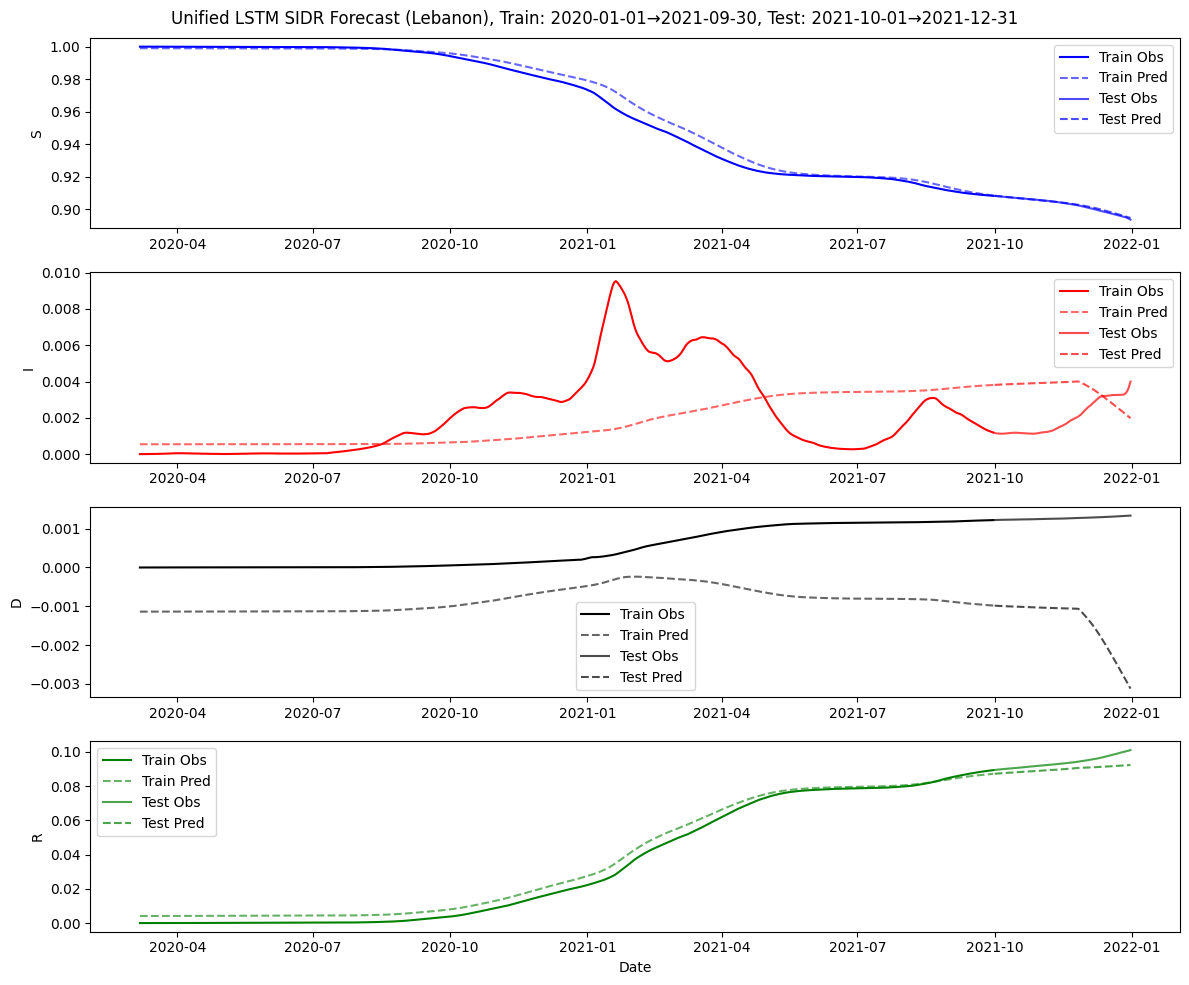

In [19]:
###############################################################################
# 5. EVALUATION & UNIFIED PLOTTING (Train + Test)
###############################################################################
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

labels = ['S','I','D','R']
print("\nRMSE on test set (fractions):")
for k, lab in enumerate(labels):
    print(f"{lab}: {rmse(y_test[:,k], y_pred[:,k]):.2e}")
print("Overall LSTM RMSE:", rmse(y_test, y_pred))

# Combine train and test predictions for unified plotting
y_pred_train = model.predict(X_train, verbose=0)

# Construct a unified timeline for plotting
train_dates = out_dates[train_mask]
test_dates = out_dates[test_mask]

plt.figure(figsize=(12, 10))

for k, (label, color) in enumerate(zip(labels, ['b', 'r', 'k', 'g'])):
    plt.subplot(4, 1, k+1)

    # Plot observed training data
    plt.plot(train_dates, y_train[:, k], color, label='Train Obs')

    # Plot LSTM predictions on training set
    plt.plot(train_dates, y_pred_train[:, k], color+'--', alpha=0.6, label='Train Pred')

    # Plot observed testing data
    plt.plot(test_dates, y_test[:, k], color, linewidth=1.5, alpha=0.7, label='Test Obs')

    # Plot LSTM predictions on testing set
    plt.plot(test_dates, y_pred[:, k], color+'--', linewidth=1.5, alpha=0.7, label='Test Pred')

    plt.ylabel(label)
    plt.legend(loc='best')

plt.xlabel("Date")
plt.suptitle(f"Unified LSTM SIDR Forecast ({country}), Train: {train_start}→{train_end}, Test: {test_start}→{test_end}")
plt.tight_layout()
plt.show()
